# Galaxy photo-z mocks and hierarchical N(z) sampling
This demo notebook is divided into three sections:
- generate a realistic galaxy survey magnitude and redshift distributions
- add noisy colors generated from a system of templates (here the CWW library)
- run the hierarchical sampling of Leistedt, Morlock & Peiris (2016) to recover the  distributions

In [18]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

# Priors

## HDFN prior from Benitez 2000

In [19]:
# This is the prior HDFN prior from Benitez 2000, adapted from the BPZ code.
# This could be replaced with any redshift, magnitude, and type distribution.
def bpz_prior(z, m, nt):
    nz = len(z)
    momin_hdf = 20.
    if m>32.: m = 32.
    if m<20.: m = 20.    
    # nt Templates = nell Elliptical + nsp Spiral + nSB starburst
    try:  # nt is a list of 3 values
        nell, nsp, nsb = nt
    except:  # nt is a single value
        nell = 1  # 1 Elliptical in default template set
        nsp = 2   # 2 Spirals in default template set
        nsb = nt - nell - nsp  # rest Irr/SB
    nn = nell, nsp, nsb
    nt = sum(nn)
    # See Table 1 of Benitez00
    a  = 2.465,  1.806,  0.906
    zo = 0.431,  0.390,  0.0626
    km = 0.0913, 0.0636, 0.123
    k_t= 0.450,  0.147
    a  = np.repeat(a, nn)
    zo = np.repeat(zo, nn)
    km = np.repeat(km, nn)
    k_t= np.repeat(k_t, nn[:2])
    # Fractions expected at m = 20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = 0.35, 0.5
    fo_t = fo_t / np.array(nn[:2])
    fo_t = np.repeat(fo_t, nn[:2])
    dm = m-momin_hdf
    zmt = np.clip(zo+km*dm,0.01,15.)
    zmt_at_a = zmt**(a)
    zt_at_a = np.power.outer(z,a)
    #Morphological fractions
    nellsp = nell + nsp
    f_t = np.zeros((len(a),),float)
    f_t[:nellsp] = fo_t*np.exp(-k_t*dm)
    f_t[nellsp:] = (1.-np.add.reduce(f_t[:nellsp]))/float(nsb)
    #Formula: zm=zo+km*(m_m_min)  and  p(z|T,m)=(z**a)*exp(-(z/zm)**a)
    p_i = zt_at_a[:nz,:nt]*np.exp(-np.clip(zt_at_a[:nz,:nt]/zmt_at_a[:nt],0.,700.))
    #This eliminates the very low level tails of the priors
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = np.where(np.less(p_i[:nz,:nt]/norm[:nt],1e-2/float(nz)),
              0.,p_i[:nz,:nt]/norm[:nt])
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = p_i[:nz,:nt]/norm[:nt]*f_t[:nt]
    return p_i

## LSST prior

In [20]:
def photoz_lsst_prior(z,imax):
    
    z0=0.0417*imax-0.744
    p=1./2./z0*(z/z0)**2*np.exp(-z/z0)
    return p
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 0, 'z')

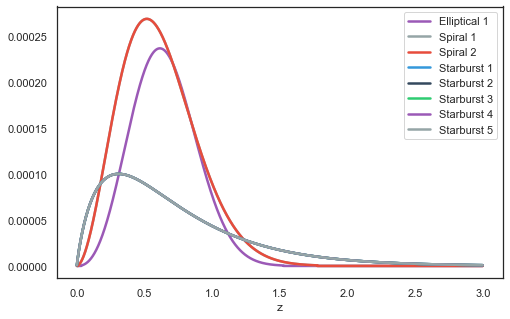

In [55]:
# This is the "fine" redshift grid we will use
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Use the p(z,t,m) distribution defined above
m = 22.0 # some reference magnitude
p_z__t_m = bpz_prior(z_grid, m, templatetypesnb)

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]
names = mknames(templatetypesnb)

# Plot the priors for these templates
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
p = ax.plot(z_grid, p_z__t_m)
ax.legend(p, labels=names)
ax.set_xlabel("z")

### In LSST science book

In [ ]:
f_prior='prior/p_z_simulcosmos.xlsx'
df=pd.read_excel(f_prior)

In [22]:
my_z=np.linspace(0.001,3,100)

Text(0.5, 1.0, 'prior on z')

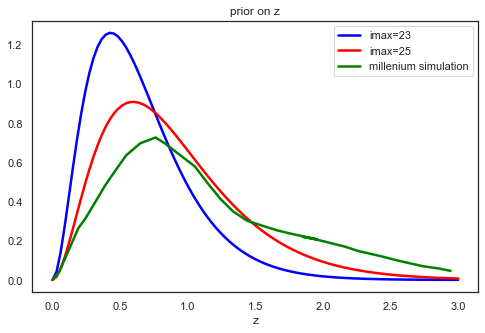

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(my_z, photoz_lsst_prior(my_z,23),"b-",label="imax=23")
ax.plot(my_z, photoz_lsst_prior(my_z,25),"r",label="imax=25")
ax.plot(df["z"],df["prior"],"g",label="millenium simulation")
ax.legend()
ax.set_xlabel("z")
ax.set_title("prior on z")

In [ ]:
# Load and plot the templates and filters
palette = itertools.cycle(sns.color_palette())
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
for i, template_name in enumerate(template_names):
    data = np.genfromtxt('./seds/'+template_name+'.sed')
    wavelength, template_sed = data[:,0], data[:,1] * data[:,0]**2
    fnorm = np.interp(7e3, wavelength, template_sed)
    axs[0].plot(wavelength, (template_sed / fnorm), label=template_names[i], 
                c=next(palette), lw=2)
axs[0].legend(loc='lower right', ncol=2)
axs[0].set_ylabel(r'$L_\nu(\lambda)$')
axs[0].set_yscale('log')
axs[0].set_ylim([1e-3, 1e2])
axs[0].set_xlabel(r'$\lambda$  [\AA]')

#ab_filters = ['u', 'g', 'r', 'i', 'z']
ab_filters = ['u', 'g', 'r', 'i', 'z','y']
palette = itertools.cycle(sns.cubehelix_palette(5, light=0.6))
#filters = [np.genfromtxt('./filters/'+band+'.dat') for band in ab_filters]
filters = [np.genfromtxt('./filters/lsst_'+band+'.res') for band in ab_filters]
for f, data in zip(ab_filters, filters):
    axs[1].plot(data[:,0], data[:,1], label=f, c=next(palette), lw=3)
axs[1].set_xlim([1e3, 1.1e4])
axs[1].set_ylim([0, 0.75])
axs[1].set_xlabel(r'$\lambda$  [\AA]')
axs[1].set_ylabel(r'$W_b(\lambda)$')
axs[1].legend(loc='upper left', ncol=3)
fig.tight_layout()

# Distributions in magnitudes

$$
P(m_i)= m_i^\alpha exp(-(m_i/m_{max})^\beta)
$$

In [ ]:
maglim = 24  # magnitude limit
off = 1.  # some offset
imag_grid = np.linspace(17, 26, num=200)  # grid for i magnitude
imagerr_grid = np.linspace(0, 0.4, num=200)  # grid for i magnitude error

# some parameters for prob(imagnitude)
alpha = 15.0 
beta = 2

# prob(imagnitude) distribution
p_imag = imag_grid**alpha*np.exp(-(imag_grid/(maglim-off))**beta)
p_imag /= p_imag.sum()

# imag errir distribution as function of mag limit, as in Rykoff et al
def imag_err(m, mlim):
    a, b = 4.56, 1
    k = 1
    sigmadet = 5
    teff = np.exp(a + b * (mlim - 21.))
    F = 10**(-0.4*(m-22.5))
    Flim = 10**(-0.4*(mlim-22.5))
    Fnoise = (Flim/sigmadet)**2 * k * teff - Flim
    return 2.5/np.log(10) * np.sqrt( (1 + Fnoise/F) / (F*k*teff))
    
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(imag_grid, p_imag)
axs[0].axvline(maglim, c='k', ls='dashed')
axs[0].set_title('p(imag | maglimit)')
axs[1].plot(imag_grid, imag_err(imag_grid, maglim))
axs[1].axvline(maglim, c='k', ls='dashed')
axs[1].set_title('Imag err = f(imag)')
axs[1].set_ylim([0, 0.8])

# Function to simulate magnitudes, galaxy type and redshift

## Draw i magnitudes from a gridded prob(imag)

In [ ]:
# Draw i magnitudes from a gridded prob(imag)
def draw_mag(nobj, imag_grid, p_imag):
    imag_grid_binsize = (imag_grid[1] - imag_grid[0])
    imag_grid_mid = (imag_grid[1:] + imag_grid[:-1])/2.0
    p_cumul = np.cumsum(p_imag) / np.sum(p_imag)
    pos = np.random.uniform(0.0, 1.0, size=nobj)
    res = np.zeros(nobj, dtype=int)
    for i in range(imag_grid.size-1):
        cond = np.logical_and(pos > p_cumul[i], pos <= p_cumul[i+1])
        res[cond] = i 
    return imag_grid_mid[res] + (np.random.rand(nobj) - 0.5)*imag_grid_binsize

In [ ]:

    
# Draw types + redshifts for given z_grid, i magnitudes, and which types are used. 
def draw_types_and_redshifts(nobj, z_grid, imags, templatetypesnb):
    types = np.zeros(nobj, dtype=int)
    z_grid_binsize = (z_grid[1]-z_grid[0])
    z_grid_mid = (z_grid[1:]+z_grid[:-1])/2.0
    redshifts = np.zeros(nobj, dtype=float)
    redshiftlocs = np.zeros(nobj, dtype=int)
    nt = np.sum(templatetypesnb)    
    for ii in range(nobj):
        pos = np.random.uniform(0.0, 1.0, size=2)
        p_ztm = bpz_prior(z_grid, imags[ii], templatetypesnb)
        p_tm = p_ztm.sum(axis=0)
        p_tm_cumul = np.cumsum(p_tm) / np.sum(p_tm)
        for i in range(p_tm_cumul.size-1):
            if pos[0] > p_tm_cumul[i] and pos[0] <= p_tm_cumul[i+1]:
                types[ii] = i + 1
                break
        p_ztm_cumul = np.cumsum(p_ztm[:,types[ii]]) / np.sum(p_ztm[:,types[ii]])
        for i in range(p_ztm_cumul.size-1):
            if pos[1] > p_ztm_cumul[i] and pos[1] <= p_ztm_cumul[i+1]:
                redshiftlocs[ii] = i + 1
                redshifts[ii] = z_grid[i + 1] + (np.random.rand(1)-0.5)*z_grid_binsize
                break
    return redshifts, redshiftlocs, types

# True simulation of catalog

In [ ]:
# Large number of objects to be generated.
nobj = 100000
imags = draw_mag(nobj, imag_grid, p_imag)
imagerrs = imag_err(imags, maglim) 
imagswitherr_all = imags + imagerrs*np.random.randn(nobj)
ind = (1./imagerrs > 5.) # Doing SNR cut - keep galaxies detected at 5 sigma only
# Change the arrays to keep these objects only
nobj = ind.sum()
imags = imags[ind]
imagerrs = imagerrs[ind]
imagswitherr = imagswitherr_all[ind]
redshifts, redshiftlocs, types = draw_types_and_redshifts(nobj, z_grid, imags, templatetypesnb)

data = np.vstack((redshifts, types, imags)).T

# Define the edges of the redshift, type and imagnitude grid
z_grid_edges_coarse = np.arange(0.0, 3.0, 0.2)
types_edges = np.arange(nt+1)-0.5
imag_grid_edges = np.linspace(16, 26, num=10)
# Compute the histogram of true z-t-m values
truth_ztm_full, _ = np.histogramdd(data[:,:], 
                                   bins=[z_grid_edges_coarse,
                                         types_edges, 
                                         imag_grid_edges])

- We've kept objects detected at 5 sigma
- this should mimic a real survey selection.
- Let's verify this with some analytic prediction

In [ ]:
# We've kept objects detected at 5 sigma
# this should mimic a real survey selection.
# Let's verify this with some analytic prediction
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()
detprob = 1*p_imag 
ind = (imag_grid >= maglim - 0.4)
detprob[ind] *= np.exp( -0.5*((imag_grid[ind]-maglim+0.4)/0.2)**2)
#detprob[ind] *= ( 1 - scipy.special.erf((imag_grid[ind]-maglim+0.4)/0.4) )
detprob /= detprob.sum() * (imag_grid[1]-imag_grid[0])
#axs[0].hist(imags, normed=True, range=[imag_grid.min(), imag_grid.max()], bins=180, histtype='step', lw=3)
axs[0].plot(imag_grid, p_imag/np.sum(p_imag)/(imag_grid[1]-imag_grid[0]))
axs[0].plot(imag_grid, detprob, color='k')
axs[0].hist(imagswitherr, density=True, range=[imag_grid.min(), imag_grid.max()], bins=80, histtype='step', lw=3)
axs[0].set_title('i magnitude distribution')
axs[1].hist(imagerrs, density=True, range=[imagerrs.min(), imagerrs.max()], bins=180, histtype='step', lw=3)
axs[1].set_title('i err magnitude distribution')
axs[2].hist(redshifts, density=True, range=[z_grid.min(), z_grid.max()], bins=80, histtype='step', lw=3)
axs[2].set_title('Redshift distribution')
axs[2].set_xlabel('z')
counts = [np.sum(types==i) for i in range(nt)]
axs[3].plot(counts)
axs[3].set_title('Number of objects of each type')
axs[3].set_xticklabels(names, rotation=90)

fig.tight_layout()

# Now plot the p(z,t,imag) priors and compare to what we've drawn

In [ ]:
# Now plot the p(z,t,imag) priors and compare to what we've drawn
fig, axs = plt.subplots(nt, 2, figsize=(14, nt*3) )
templates = np.zeros((imag_grid.size, z_grid.size))
for i in range(nt):
    for j in range(imag_grid.size):
        templates[j,:] = bpz_prior(z_grid, imag_grid[j], templatetypesnb)[:,i]
    axs[i,0].plot(z_grid, templates[:,:].T)
    axs[i,0].set_title(names[i])

templates = np.zeros((imag_grid.size, z_grid.size))
for i in range(nt):
    ind = (types==i)
    for j in range(imag_grid.size):
        templates[j,:] = bpz_prior(z_grid, imag_grid[j], templatetypesnb)[:,i]
        templates[j,:] /= np.max(templates[j,:] )
    axs[i,1].pcolormesh(z_grid, imag_grid, templates)
    H, xedges, yedges = np.histogram2d(redshifts[ind], imags[ind], bins=20, range=[[z_grid.min(), z_grid.max()], [imag_grid.min(), imag_grid.max()]])
    axs[i,1].contour(xedges[1:],yedges[1:],H.T)
    axs[i,1].set_title(names[i])
    axs[i,1].set_ylabel('i mag')
axs[-1, 1].set_xlabel('z')
axs[-1, 0].set_xlabel('z')
plt.tight_layout()

# Simulation of photoz magnitudes

In [ ]:
# Let's truncate all these arrays and only keep a smaller number of objects
nobj = 10000
#nobj = 20000
imags = imags[0:nobj]
imagerrs = imagerrs[0:nobj]
imagswitherr = imagswitherr[0:nobj]
redshifts = redshifts[0:nobj] 
redshiftlocs = redshiftlocs[0:nobj] 
types = types[0:nobj] 

filters = ['u', 'g', 'r', 'i', 'z','y'] # Which bands are used
reffilter = 2 # Which one is the reference? i band by default but could be anything.

# Approximate luminosity distance for flat LCDM
def DL(z):
    return np.exp(30.5 * z**0.04 - 21.7)

# We will now use the BPZ routines to load the magnitude-redshift model for each template.
# We'll have interpolated and discretized versions
nf = len(filters)
nz = len(z_grid)
f_mod = np.zeros((nz,nt,nf))*0.
f_mod_interps = np.zeros((nt, nf), dtype=interp1d)
lambdaRef = 4.5e3
for it in range(nt):
    seddata = np.genfromtxt('./seds/' + template_names[it] + '.sed')
    seddata[:, 1] *= seddata[:, 0]**2. / 3e18
    ref = np.interp(lambdaRef, seddata[:, 0], seddata[:, 1])
    seddata[:, 1] /= ref
    sed_interp = interp1d(seddata[:, 0], seddata[:, 1])
    for jf in range(nf):
        #data = np.genfromtxt('./filters/' + filters[jf] + '.dat')
        data = np.genfromtxt('./filters/lsst_' + filters[jf] + '.res')
        xf, yf = data[:, 0], data[:, 1]
        yf /= xf  # divide by lambda
        # Only consider range where >1% max
        ind = np.where(yf > 0.01*np.max(yf))[0]
        lambdaMin, lambdaMax = xf[ind[0]], xf[ind[-1]]
        norm = np.trapz(yf, x=xf)
        for iz in range(z_grid.size):
            opz = (z_grid[iz] + 1)
            xf_z = np.linspace(lambdaMin / opz, lambdaMax / opz, num=5000)
            yf_z = interp1d(xf / opz, yf)(xf_z)
            ysed = sed_interp(xf_z)
            f_mod[iz, it, jf] = np.trapz(ysed * yf_z, x=xf_z) / norm
            f_mod[iz, it, jf] *= opz**2. / DL(z_grid[iz])**2. / (4*np.pi)
        f_mod_interps[it, jf] = InterpolatedUnivariateSpline(z_grid, f_mod[:, it, jf])

In [ ]:
# f_mod denotes the (discretized or continuous) model magnitude-redshift curves
# Let's now get magnitudes for all the objects we've drawn
f_obs_err = np.zeros((nobj,nf), dtype=float) # magnitude error
f_obs_noerr = np.zeros((nobj,nf), dtype=float) # noiseless magnitude
f_obs = np.zeros((nobj,nf), dtype=float)  # noisy magnitude
#types = np.array(types.astype(int))
for jf in range(nf):
    if jf == reffilter:
        f_obs_err[:,reffilter] = imagerrs * (1 + 0.05* np.random.randn(nobj))
        f_obs[:,reffilter] = imags + f_obs_err[:,reffilter] * np.random.randn(nobj)
        f_obs_noerr[:,reffilter] = imags
    else:
        cmod = np.array([-2.5*np.log10(np.clip(
                        f_mod_interps[types[i],jf](redshifts[i])/f_mod_interps[types[i],reffilter](redshifts[i])
                        ,1e-5,1e5)) for i in range(nobj)])
        f_obs_err[:,jf] = imagerrs * (1 + 0.05* np.random.randn(nobj))
        f_obs[:,jf] = imags + cmod + f_obs_err[:,jf] * np.random.randn(nobj)
        f_obs_noerr[:,jf] = imags + cmod 

In [ ]:
# Let's visualize the magnitudes
fig, axs = plt.subplots(1, nf, figsize=(15,3))
for jf in range(nf):
    axs[jf].hist(f_obs[:,jf], density=True, 
                 range=[imag_grid.min(), imag_grid.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig.tight_layout()
    
fig, axs = plt.subplots(1, nf, figsize=(15,3))
for jf in range(nf):
    axs[jf].hist(f_obs_err[:,jf], density=True, bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')
fig.tight_layout()

In [ ]:
# Let's plot the model and the noisy magnitudes for our mock catalogue
fig, axs = plt.subplots(nt, nf-1, figsize=(15,nt*2), sharex=True, sharey=False)
for it in range(nt):
    ind = (types == it)
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*np.log10(np.clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        colourobj = f_obs[:,jf] - f_obs[:,jf+1]
        p = theax.scatter(redshifts[ind], colourobj[ind], c='k', s=1)
        p = theax.plot(z_grid, colour)
        theax.set_title(names[it])
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
for jf in range(nf-1):
    axs[-1,jf].set_xlabel('Redshift')
theax.set_xlim([0,3])
fig.tight_layout()

In [ ]:
# Another way to visualize it: colours vs colours
cols = sns.color_palette("hls", nt)
fig, axs = plt.subplots(2, (nf-1)*(nf-2)//4, figsize=(15, 6))
axs = axs.ravel()
off = - 1
for jf in range(nf-1):
    for jf2 in range(jf):
        off += 1
        for it in range(nt):
            ind = (types == it)
            colourobj1 = f_obs[ind,jf] - f_obs[ind,jf+1]
            colourobj2 = f_obs[ind,jf2] - f_obs[ind,jf2+1]
            p = axs[off].scatter(colourobj1, colourobj2, color=cols[it], s=1)
            axs[off].set_ylabel(filters[jf]+' - '+filters[jf+1])
            axs[off].set_xlabel(filters[jf2]+' - '+filters[jf2+1])
fig.tight_layout()

In [ ]:
# This is a scale-free likelihood function, marginalizing over the scale of the magnitudes
def scalefree_flux_likelihood(f_obs, f_obs_var,
                              f_mod, returnChi2=False):
    nz, nt, nf = f_mod.shape
    var = f_obs_var  # nz * nt * nf
    invvar = np.where(f_obs/var < 1e-6, 0.0, var**-1.0)   # nz * nt * nf
    FOT = np.sum(f_mod * f_obs * invvar, axis=2)  # nz * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)  # nz * nt
    FOO = np.dot(invvar, f_obs**2)  # nz * nt
    ellML = FOT / FTT
    chi2 = FOO - FOT**2.0 / FTT  # nz * nt
    like = np.exp(-0.5*chi2) / np.sqrt(FTT)  # nz * nt
    if returnChi2:
        return chi2 + FTT, ellML
    else:
        return like, ellML

# Update (April 2020)
There is an error in this notebook: the simulation has gaussian noise in magnitude space, but the likelihood function is defined in flux space. This has little effect on the results thanks to the signal-to-noise and also the use of the scale-free likelihoods. But if you are replicating this work or applying it to real data be careful to manipulate the noise and the likelihood in a consistent manner.

In [ ]:
# Let's use the same templats to compute the likelihood functions of all these objects
fac = 200 # This is a resolution factor
# We need to compute the likelihood at high resolution and then bin it.
# the low resolution binsize is fac * bpz_z_binsize
types_edges = np.arange(nt+1)-0.5

# ff_obs is for fluxes, f_obs is for colors
# We now need to compute the flux and flux errors from colors
ff_obs = (10.**(-.4*f_obs))
ff_obs_err = (10.**(.4*np.abs(f_obs_err))-1.)*ff_obs
f_mod_log = -2.5*np.log10(f_mod)

# This is just a bunch of redefinitions to re-bin all useful quantities
# Into a coarcer redshift binning
z_grid_binsize2 = fac * z_grid_binsize
if fac == 1:
    z_grid_edges2 = 1*z_grid_edges
else:
    z_grid_edges2 = np.array([z_grid_edges[i] for i in np.arange(0, z_grid_edges.size, fac)])
z_grid2 = (z_grid_edges2[1:] + z_grid_edges2[:-1])/2.0
len_new = z_grid.size // fac

# Compute likelihood for each object
bpz_like_fine_multitypes = np.zeros((nobj, z_grid.size, nt), dtype=float) # Binned liklihood at full resolution
bpz_like_multitypes = np.zeros((nobj, z_grid2.size, nt), dtype=float) # Coarce binned likelihood 
for i in range(nobj):
    if i % 1000 == 0: 
        print(i, end=" ") # Print number every 1000 objects.
    new_f_mod = f_mod[:,:,:] / f_mod.mean(axis=2)[:, :, None]
    scafac = 1/np.mean(ff_obs[i,:])
    ff, ellML = scalefree_flux_likelihood(scafac*ff_obs[i,:], (scafac*ff_obs_err[i,:])**2., new_f_mod)
    bpz_like_fine_multitypes[i,:,:] = ff # Fine resolution
    for kk in range(len_new):
        bpz_like_multitypes[i,kk,:] = np.mean(ff[kk*fac:(kk+1)*fac,:], axis=0) # Re-bin
    # in case of problem:
    if(np.sum(ff[:, types[i]]) == 0 or np.sum(bpz_like_multitypes[:, types[i]]) == 0):
        print(i, bpz_like_fine_multitypes.sum(axis=1), bpz_like_multitypes.sum(axis=1))
        stop

In [ ]:
# plot likelihood function for a few randomly picked objects
# color coded by type.
fig2, axs = plt.subplots(4, 3, figsize=(8, 8), sharex=False, sharey=False)
axs = axs.ravel()
ri = np.random.choice(np.arange(nobj), axs.size, replace=False)
for i in range(len(ri)):
    theax = axs[i]
    theax.plot(z_grid, bpz_like_fine_multitypes[ri[i],:,:], lw=2)
    #theax.plot(z_grid2, bpz_like_multitypes[ri[i],:,:], lw=2)
    theax.axvline(redshifts[ri[i]], ls='dashed', c='k')
    theax.set_title(r'Likelihood $p(F|z,t)$')
    theax.set_xlabel(r'Redshift $z$')
fig2.tight_layout()

In [ ]:
# Also need to multiply with gaussian likelihood for reference magnitude, since we will infer p(z, t, m)
def gauss_like_int(grid_edges, mus, sigmas):
    nobj = mus.size
    nz = grid_edges.size-1
    res = np.zeros((nobj, nz))
    fac = np.sqrt(2) * sigmas
    for iz, (zlo, zhi) in enumerate(zip(grid_edges[:-1], grid_edges[1:])):
        res[:,iz] = np.abs(-(erfc((zhi-mus)/fac) - erfc((zlo-mus)/fac))/2.0)
    return res

In [ ]:
nm = 10
nz2 = z_grid2.size
imag_grid_edges = np.linspace(16, 26, num=nm+1)
imag_grid = (imag_grid_edges[1:] + imag_grid_edges[:-1])/2.0
bpz_like_ztm = np.zeros((nobj, nz2, nt, nm), dtype=float)

# gaussian likelihood
imaglike = gauss_like_int(imag_grid_edges, f_obs[:,reffilter], f_obs_err[:,reffilter])

# bpz likelihood
for i in range(nobj):
    bpz_like_ztm[i,:,:,:] = np.outer(bpz_like_multitypes[i,:,:], imaglike[i,:]).reshape((nz2, nt, nm))
    
imaglocs = np.zeros((nobj,), dtype=int)
for iz, (zlo, zhi) in enumerate(zip(imag_grid_edges[:-1], imag_grid_edges[1:])):
    ind = np.logical_and(imags > zlo, imags <= zhi)
    if ind.sum()>0:
        imaglocs[ind] = iz

In [ ]:
nobj

In [ ]:
# Compute z_MAP in case it is useful, and also write likelihoods to 4 files
z_grid_full = np.outer(z_grid, np.ones(nt)).ravel()
zpeaks = np.zeros((nobj,), dtype=float)
for i in range(nobj):
    if i % 1000 == 0:
        print(i, end=" ")
    pospeak = np.argmax(bpz_like_multitypes[i,:,:].ravel())
    zpeaks[i] = z_grid_full[pospeak]
    if i % 1000 == 0:
        print("pospeak = ",pospeak," zpeaks = ", zpeaks[i])

In [ ]:
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [ ]:
# Save each chunk of 4D python numpy array into files
nchunks = 4
lines_out = np.arange(nobj)#lines#np.arange(nobj_selec)
for i, ind in enumerate(chunks(lines_out, nchunks)):
    fname = 'bpz_sim_histlike_ztm_'+str(nchunks)+'_'+str(i+1)+'.npy'
    np.save(fname, bpz_like_ztm[ind,:,:,:])

In [ ]:
i=0
fname = 'bpz_sim_histlike_ztm_'+str(nchunks)+'_'+str(i+1)+'.npy'
fname

In [ ]:
arr=np.load(fname)

In [ ]:
arr.shape

In [ ]:
!ls

In [ ]:
from mpi4py import MPI
import numpy as np
import sys
import time


def bayeshist(filename_in,nsampl_gibbs,ini=None):
    
#!/usr/bin/env python


# 	Input 1 (required) : file name for inputs (likelihoods)
# 	Input 2 (required) : number of Gibbs samples 
# 	Input 3 (optional) : file name for input initialisation

    # Parse inputs
    #assert len(sys.argv) <= 3, "The number of inputs should be <= 3"
    #infilename = sys.argv[1]
    infilename = filename_in
    #nsamples = int(sys.argv[2])
    nsamples = nsampl_gibbs
    #if len(sys.argv) > 3:
    fname_ini = ini
        
    burnin_fraction = 0.3

    comm = MPI.COMM_WORLD
    MPI_size = comm.Get_size()
    MPI_rank = comm.Get_rank()

    if MPI_rank == 0:
        print('Input parameters:', 2)
        print('Running on %d cores' % MPI_size)

    def dirichlet(rsize, alphas):
        gammabs = np.array([np.random.gamma(alpha+1, size=rsize) for alpha in alphas])
        fbs = gammabs / gammabs.sum(axis=0)
        return fbs.T

    pdfints_npfile = infilename+'_'+str(MPI_rank+1)+'.npy'
    
    print("pdfints_npfile  = ",pdfints_npfile )
    
    pdfints = np.load(pdfints_npfile)
    sh = pdfints.shape
    nobj = sh[0]
    print('Read file', pdfints_npfile, 'and found', nobj, 'objects')
    nbins = np.prod(sh[1:])
    pdfints = pdfints.reshape((nobj, nbins))


    if MPI_rank == 0:
        if len(sys.argv) > 3:
            print('Initialised sampler with file', fname_ini)
            hbs = np.load(fname_ini).reshape((nbins,))
            hbs /= hbs.sum()
        else:# random initialisation
            nbs = np.random.rand(nbins)
            hbs = dirichlet(1, nbs)
    else:
        hbs = None

    comm.Barrier()

    hbs = comm.bcast(hbs, root=0)
    if MPI_rank == 0:
        print('Broadcasted hbs')

    if MPI_rank == 0:
        fbs = np.zeros( (nsamples, nbins) )
        tstart = time.time()

    comm.Barrier()
    ibins = np.repeat(np.arange(1, nbins), nobj).reshape((nbins-1, nobj)).T.ravel()
    for kk in range(1, nsamples):

        prods = (pdfints * hbs)
        cumsumweights = np.add.accumulate(prods, axis=1).T #cumsumweights = prods.cumsum(axis=1).T 
        cumsumweights /= cumsumweights[-1,:]
        pos = np.random.uniform(0.0, 1.0, size=nobj)
        cond = np.logical_and(pos > cumsumweights[:-1,:], pos <= cumsumweights[1:,:])
        res = np.zeros(nobj, dtype=int)
        res[pos <= cumsumweights[0,:]] = 0
        locs = np.any(cond, axis=0)
        res[locs] = ibins[cond.T.ravel()]
        ind_inrange = np.logical_and(res > 0, res < nbins)
        nbs = np.bincount(res[ind_inrange], minlength=nbins)

        nbs_all = np.zeros_like(nbs)
        comm.Allreduce(nbs, nbs_all, op=MPI.SUM)

        if MPI_rank == 0:

            if kk % 10 == 0:
                #print kk
                tend = time.time()
                fname = infilename + '_post.npy'
                ss = int(burnin_fraction*kk)
                sh2 = tuple([kk-ss]+list(sh[1:]))
                print('Saving', kk-ss, 'samples to', fname, '(%.2f' % (float(tend-tstart)/kk), 'sec per sample)')
                np.save(fname, fbs[ss:kk, :].reshape(sh2))

            hbs = dirichlet(1, nbs_all) #### PLUS ONE HERE OR NOT?? ???? ??? 

        hbs = comm.bcast(hbs, root=0)

        if MPI_rank == 0:
            fbs[kk,:] = hbs


In [ ]:
# Run the following command in the terminal to run the Hierarchical sampler
# of Leistedt, Morlock & Pedediris (2016) in parallel over the 4 chuncks.
# Try with 1000 and then move to 1e4 samples.
# Don't use with >100,000 objects because it is memory greedy! 
# There is a new light version of the model+sampler coming.

#mpirun -np 4 ./bayeshist.py bpz_sim_histlike_ztm_4 1000

#%run ./bayeshist.py bpz_sim_histlike_ztm_4 1000

bayeshist("bpz_sim_histlike_ztm_4",1000)

#stop # To make sure you don't run the full notebook without stopping here.

In [ ]:
# Produce some useful quantities
data = np.vstack((redshifts, types, imags)).T
hist_noiseless_ztm_full, edges_full = np.histogramdd(data[:,:], bins=[z_grid_edges, types_edges, imag_grid_edges])
hist_noiseless_ztm, edges = np.histogramdd(data[lines_out,:], bins=[z_grid_edges2, types_edges, imag_grid_edges])
fbs_samples_ztm = np.load('bpz_sim_histlike_ztm_4_post.npy')
fbs_samples_ztm[:,-1,:,:] -= np.mean(fbs_samples_ztm[:,-1,:,:], axis=0) - 1.2*hist_noiseless_ztm[-1,:,:] / float(np.sum(hist_noiseless_ztm[:,:,:]))
nsamples, nz, nt, nm = fbs_samples_ztm.shape

In [ ]:
# Plot the results!
# Here, the truth + violin plots of the sampled N(z) per type with magnitude marginalized. 
fig, axs = plt.subplots(nt, 2, figsize=(6, 10), sharex=True)
fbs_samples_zt = fbs_samples_ztm[:,:,:,:].sum(axis=3)
N_truth = float(truth_ztm_full.sum())

linewidth = 1.5
binsize = (z_grid2[1] - z_grid2[0])
hist_noiseless_zt = truth_ztm_full.sum(axis=2)
hist_noiseless_zt_full = truth_ztm_full.sum(axis=2)
N = float(truth_ztm_full.sum())
for i in range(nt):
    ind = np.where(types[lines_out] == i)[0] 
    
    N_t = float(hist_noiseless_zt[:,i].sum())
    stacked_like = bpz_like_ztm[:,:,i,:].sum(axis=2).mean(axis=0) #/ N_t
    truth = hist_noiseless_zt[:,i] / N_truth
    
    indv = (truth > np.max(truth)/50.0)
    offset = z_grid_binsize2/18
    ax = axs[i, 0]
    ax.plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
            np.concatenate(([truth[0]], truth)), color='k', lw=linewidth, 
            drawstyle='steps', label='True distribution')
    
    df = pd.DataFrame(fbs_samples_zt[:,:,i], columns=z_grid2)
    sns.violinplot(df, width=4*binsize, scale_hue=False, scale='width', ax=ax,inner=None, palette="coolwarm")
    v1, v2 = ax.get_ylim()
    ax.set_ylim([0, v2])
    if i == 1:
        ax.set_ylim([0, 0.11])
    ax.set_ylim([0, 0.95*v2])
    ax.set_xticks(np.arange(0, 3, 0.5)/binsize)
    ax.set_xticklabels(np.arange(0, 3, 0.5))
    ax.set_ylabel(names[i])
    
    ax = axs[i, 1]
    ax.plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
            np.concatenate(([0], 0*truth)), color='k', lw=linewidth, marker=None)
    df = pd.DataFrame((fbs_samples_zt[:,:,i]-truth), columns=z_grid2)
    sns.violinplot(df, width=4*binsize, scale_hue=False, scale='width', ax=ax,inner=None, palette="coolwarm")
    v1, v2 = ax.get_ylim()
    v3 = np.max([np.abs(v1), np.abs(v2)])
    #v3 = 0.024
    ax.set_ylim([-v3, v3])
    ax.set_xticks(np.arange(0, 3, 0.5)/binsize)
    ax.set_xticklabels(np.arange(0, 3, 0.5))
axs[0, 0].set_title(r'$N(z)$')
axs[0, 1].set_title(r'$N(z)$ residuals')
axs[-1, 0].set_xlabel(r'Redshift $z$')
axs[-1, 1].set_xlabel(r'Redshift $z$')
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

In [ ]:
# Same but with type marginalized.
fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharex=False)
axs = [axs]
stacked_like = bpz_like_ztm[:,:,:].sum(axis=3).sum(axis=2).sum(axis=0)
stacked_like /= nobj
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)
hist_noiseless_z = hist_noiseless_ztm.sum(axis=(1,2))
hist_noiseless_z /= hist_noiseless_z.sum()
df = pd.DataFrame(fbs_samples_z[:,:], columns=z_grid2)
t1 = sns.violinplot(df, width=4*binsize, scale_hue=False, scale='width', ax=axs[0],inner=None, palette="coolwarm", label=r'Recovered distribution')
t3 = axs[0].plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
            np.concatenate(([0], hist_noiseless_z)), color='k', lw=linewidth, 
            drawstyle='steps', label=r'True distribution')
axs[0].legend()
axs[0].set_ylabel(r'$N(z)$')
axs[0].set_xlabel(r'Redshift $z$')
fig.tight_layout()

In [ ]:
# Now plot the samples of the full model versus a naive dirichlet,
# To show the impact of the model hierarchy and also bin-bin correlations.

def dirichlet(size, alphas):
    gammabs = np.array([np.random.gamma(alpha+1, size=size) for alpha in alphas])
    fbs = gammabs / gammabs.sum(axis=0)
    return fbs.T

from corner import hist2d
myrange = np.arange(0, 14)

fig, axs = plt.subplots(myrange.size, myrange.size, figsize=(13, 13), sharex=False, sharey=False)
#axs = axs.ravel()
off = 0
lw = 1
nbins = 20
hist_noiseless_z = hist_noiseless_ztm.sum(axis=2).sum(axis=1)
truth_z = truth_ztm_full.sum(axis=2).sum(axis=1)
truth = truth_z / float(truth_ztm_full.sum())
#fbs_samples_z_noerrors = dirichlet(2e4, hist_noiseless_z)
nobnoe = int(1e5)
fbs_samples_ztm_noerrors = dirichlet(nobnoe, hist_noiseless_ztm.ravel()).reshape((nobnoe, nz, nt, nm))
fbs_samples_z_noerrors = fbs_samples_ztm_noerrors[:,:,:,:].sum(axis=3).sum(axis=2)
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)
levels = 1.0 - np.exp(-0.5 * np.arange(1.0, 2.1, 1.0) ** 2)
sc = 4
formatter = FormatStrFormatter('%.3f')
for ibin in myrange:
    mi = truth[ibin]#
    mmi = np.mean(fbs_samples_z[:,ibin])
    si = np.std(fbs_samples_z[:,ibin])
    ri = [max([0, mi-sc*si]), mi+sc*si]
    for jbin in myrange:
        mj = truth[jbin]#
        mmj = np.mean(fbs_samples_z[:,jbin])
        sj = np.std(fbs_samples_z[:,jbin])
        rj = [max([0, mj-sc*sj]), mj+sc*sj]
        theax = axs[ibin-myrange[0], jbin-myrange[0]]
        theax.locator_params(nbins=2)
        txt = str(ibin+1)+'-th bin, $z\in[%1.2g' % (z_grid[jbin]-binsize/2)+', %1.2g' % (z_grid[jbin]+binsize/2)+']$'
        txt = ''
        if (jbin < ibin):
            off += 1
            theax.axvline(truth[jbin], color='gray', ls='dashed')
            theax.axhline(truth[ibin], color='gray', ls='dashed')
            theax.set_yticks([truth[ibin]])
            theax.set_xticks([truth[jbin]])
            theax.yaxis.set_major_formatter(formatter)
            theax.xaxis.set_major_formatter(formatter)
            hist2d(fbs_samples_z_noerrors[:,jbin], fbs_samples_z_noerrors[:,ibin], #range=[ri, rj],
                   bins=nbins, ax=theax, color='red', hist2d_kwargs={'linewidth': lw},
                   plot_density=False, plot_datapoints=False, levels=levels)
            hist2d(fbs_samples_z[:,jbin], fbs_samples_z[:,ibin], #range=[ri, rj],
                   bins=nbins, ax=theax, color='k', hist2d_kwargs={'linewidth': lw},
                   plot_density=False, plot_datapoints=False, levels=levels)
            theax.scatter(truth[jbin], truth[ibin], marker='s', s=50, color='k')
    
            theax.set_xlim(rj)
            theax.set_ylim(ri)
        else:
            if ibin == jbin:
                theax.set_title(txt, fontsize=15)
                y, x = np.histogram(fbs_samples_z[:,ibin], bins=2*nbins, range=ri)
                theax.plot((x[1:]+x[:-1])/2., y/float(y.max()), 'k')
                y, x = np.histogram(fbs_samples_z_noerrors[:,ibin], bins=2*nbins, range=ri)
                theax.plot((x[1:]+x[:-1])/2., y/float(y.max()), 'r')
                theax.axvline(truth[ibin], color='gray', ls='dashed')
                theax.set_yticks([])
                theax.set_xlim(ri)
                theax.set_ylim([0, 1.1])
                theax.set_xticks([truth[ibin]])
                theax.xaxis.set_major_formatter(formatter)
            else:
                plt.delaxes(theax)
        if (jbin > myrange[0]):
            theax.set_yticklabels([])
        if (ibin < myrange[-1]):
            theax.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)